# Imports and Configs

In [28]:
import math
import numpy as np
import random as rn
from numpy.random import uniform as rnd, normal as rndn
import statistics

In [29]:
# class to print text in different colors
class bcolors:
  HEADER = '\033[95m'
  OKBLUE = '\033[94m'
  OKCYAN = '\033[96m'
  OKGREEN = '\033[92m'
  WARNING = '\033[93m'
  FAIL = '\033[91m'
  ENDC = '\033[0m'
  BOLD = '\033[1m'
  UNDERLINE = '\033[4m'

# Benchmark functions


In [30]:
def ackley(d=0, data=[]):
  a = 20
  b = 0.2
  c = 2 * np.pi

  D = 1 / d

  term_1 = 0
  term_2 = 0

  for i in range(1,d):
    term_1 += data[i] ** 2
    term_2 += np.cos(c * data[i])

  f = -a * np.exp(-b * np.sqrt(term_1)) - np.exp(term_2) + a + np.exp(1)

  if f < 10 ** (-16):
    f = 0

  return f

In [31]:
def rastrigin(d=0, data=[]):
  sum = 0

  for i in range(d):
    sum += data[i] ** 2 - 10 * np.cos(2 * np.pi * data[i])

  f = 10 * d + sum

  if f < 10 ** (-16):
    f = 0
    
  return f

In [32]:
def rosenbrock(d=0, data=[]):
  sum = 0

  for i in range(1, d-1):
    sum += 100 * (data[i+1] - data[i] ** 2) ** 2 + (data[i] - 1) ** 2   

  if sum < 10 ** (-16):
    sum = 0

  return sum

In [33]:
def schwefel(d=0, data=[]):
  sum = 0

  for i in range(d):
    sum += data[i] * np.sin(np.sqrt(np.absolute(data[i])))
  
  f = 418.9829 * d - sum

  if f < 10 ** (-16):
    f = 0

  return f

In [34]:
class Function:
  def __init__(self, id):
    if id == 1:
      self.name = 'Ackley'
      self.fnc = ackley
      self.low = -32
      self.up = 32
    elif id == 2:
      self.name = 'Rastrigin'
      self.fnc = rastrigin
      self.low = -5.12
      self.up = 5.12
    elif id == 3:
      self.name = 'Rosenbrock'
      self.fnc = rosenbrock
      self.low = -30
      self.up = 30
    elif id == 4:
      self.name = 'Schwefel'
      self.fnc = schwefel  
      self.low = -500 
      self.up = 500 
    else:
      return

    def __str__(self):
      return f"{self.name}"

# BSA


In [35]:
class Global_Params:

  def __init__(self, fnc=None, pop_size=0, dim=0, maxCycle=0, mixRate=0, low=0, up=0):
    self.fnc = fnc
    self.pop_size = pop_size
    self.dim = dim
    self.maxCycle = maxCycle
    self.mixRate = mixRate
    self.low = low
    self.up = up

  def __str__(self):
    return f" Func: {self.fnc}\n Pop_size: {self.pop_size}\n Dim: {self.dim}\n MaxCycle: {self.maxCycle}\n MixRate: {self.mixRate}\n Low: {self.low}\n Up: {self.up}\n NbRuns: {self.nbRuns}"

In [36]:
class Population:

  def __init__(self, pop_size, dim):
    self.data = np.ones((pop_size, dim))

  def print(self):
    [rows, cols] = self.data.shape
    print("[")
    for i in range(rows):
      print("   [", end=' ')
      for j in range(cols):
        print(self.data[i][j], end='\t')
      
      print("]")
    print("]")

  def permute(self):
    np.random.permutation(self.data)

  def generateValue(self, low, up):
    val = rnd(0, 1) * ( up - low ) + low
    return float(format(val, '.3f')) 

  def setValue(self, row, col, value):
    self.data[row][col] = value

  def getValue(self, row, col):
    return self.data[row][col]

In [37]:
class BSA:

  def __init__(self, params):
    self.globalMin = float('inf')
    self.globalMins = []
    self.globalMinimizer = []
    self.params = params
    
  def initialize(self):
    self.p = Population(self.params.pop_size, self.params.dim)
    self.oldP = Population(self.params.pop_size, self.params.dim)
    self.fitP = []

    for i in range(self.params.pop_size):
      for j in range(self.params.dim):
        self.p.setValue(i, j, self.p.generateValue(self.params.low, self.params.up))
        self.oldP.setValue(i, j, self.oldP.generateValue(self.params.low, self.params.up))
        
      self.fitP.append(self.params.fnc(self.params.dim, self.p.data[i]))

  def selection_1(self):
    for i in range(self.params.pop_size):
      for j in range(self.params.dim):
        if rnd(0, 1) < rnd(0, 1):
          self.oldP.setValue(i,j, self.p.getValue(i, j))

    self.oldP.permute()

  def mutation(self):
    self.mutant = Population(self.params.pop_size, self.params.dim)

    for i in range(self.params.pop_size):
      for j in range(self.params.dim):
        F = round((3 * rndn(0, 1)), 3)
        temp = self.p.getValue(i,j) + (self.oldP.getValue(i,j) - self.p.getValue(i,j)) * F
        self.mutant.setValue(i, j, temp)

  def crossover(self):
    self.map = Population(self.params.pop_size, self.params.dim)
    temp = int(np.ceil(self.params.mixRate * self.params.dim * rnd(0, 1) ))

    if rnd(0, 1) < rnd(0, 1):
      for i in range(self.params.pop_size):
        u = np.random.permutation(self.params.dim)
        for k in u[1:temp]:
          self.map.setValue(i, k, 0)
    else:
      for i in range(self.params.pop_size):
        temp = rn.randrange(1, self.params.dim+1) - 1
        self.map.setValue(i, temp, 0)

  def generate_trial(self):
    self.T = Population(self.params.pop_size, self.params.dim)

    for i in range(self.params.pop_size):
      for j in range(self.params.dim):
        if self.map.getValue(i, j) == 1:
          self.T.setValue(i, j, self.p.getValue(i, j))
        else:
          self.T.setValue(i, j, self.mutant.getValue(i, j))

  def boundary_control(self): 
    for i in range(self.params.pop_size):
      for j in range(self.params.dim):
        curValue = self.T.getValue(i, j)
        if curValue < self.params.low or curValue > self.params.up:
          temp = self.T.generateValue(self.params.low, self.params.up)
          self.T.setValue(i, j, temp)

  def selection_2(self):
    self.fitT = []
  
    for i in range(self.params.pop_size):
      self.fitT.append(self.params.fnc(self.params.dim, self.T.data[i]))

      if self.fitT[i] < self.fitP[i]:
        self.fitP[i] = self.fitT[i]
        
        for j in range(self.params.dim):
          self.p.setValue(i, j, self.T.getValue(i, j))

  
  def set_minimum(self):
    fitPBestValue = min(self.fitP)
    fitPBestIndex = self.fitP.index(fitPBestValue)
    if fitPBestValue < self.globalMin:
      self.globalMin = fitPBestValue
      self.globalMinimizer = self.p.data[fitPBestIndex].copy() 


  def stats(self):
    # print(self.globalMins)
    print(f"{bcolors.OKGREEN}Mean:\t {statistics.mean(self.globalMins)}{bcolors.ENDC}")
    print(f"{bcolors.OKGREEN}Variance:\t {statistics.variance(self.globalMins)}{bcolors.ENDC}")
    print(f"{bcolors.OKGREEN}Standard deviation:\t {statistics.stdev(self.globalMins)}{bcolors.ENDC}")
    print(f"{bcolors.OKGREEN}Best:\t {min(self.globalMins)}{bcolors.ENDC}")
    print(f"{bcolors.OKGREEN}Worst:\t {max(self.globalMins)}{bcolors.ENDC}")

  def launch(self):
    self.initialize()
    print(bcolors.OKGREEN + '-' * 500 + bcolors.ENDC)
    for i in range(self.params.maxCycle):
      self.selection_1()
      self.mutation()
      self.crossover()
      self.generate_trial()
      self.boundary_control()
      self.selection_2()
      self.set_minimum()

      print(f"{bcolors.BOLD}BSA: {i} -----------------------------------> {self.globalMin} {bcolors.ENDC}")
      
      if i < 29:
        self.globalMins.append(self.globalMin)

      if i == 29:
        self.stats()
        
    print(bcolors.OKGREEN + "-" * 500 + bcolors.ENDC)

In [38]:
class App:

  def launch(self):
    choise = -1
    print("Backtracking Search Optimization Algorithm")
    print("--------------------------")
    print("The list of functions: ")
    print("1. Ackley function")
    print("2. Rastrigin function")
    print("3. Rosebrock function")
    print("4. Schewel function")
    print("--------------------------")
    
    while choise < 1 or choise > 4:
      choise = int(input("Please choose the function from the list: "))

    function = Function(choise)
    params = Global_Params(function.fnc, 30, 30, 1000, 1, function.low, function.up)
    self.bsa = BSA(params)    

In [39]:
app = App()
app.launch()
app.bsa.launch()

Backtracking Search Optimization Algorithm
--------------------------
The list of functions: 
1. Ackley function
2. Rastrigin function
3. Rosebrock function
4. Schewel function
--------------------------
Please choose the function from the list: 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BSA: 0 -----------------------------------> 0 
BSA: 1 -----------------------------------> 0 
BSA: 2 -----------------------------------> 0 
BSA: 3 -----------------------------------> 0 
BSA: 4 -----------------------------------> 0 
BSA: 5 ---------

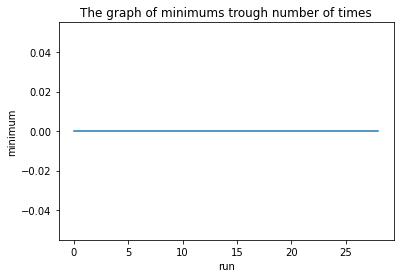

In [40]:
import matplotlib.pyplot as plt
plt.plot(range(29), app.bsa.globalMins)

plt.ylabel('minimum')

plt.xlabel('run')
 
plt.title('The graph of minimums trough number of times')
 
plt.show()